In [ ]:
import yaml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib as mpl
# Use the pgf backend (must be done before import pyplot interface)
mpl.use('pgf')
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    # "text.usetex": True,     # use inline math for ticks
    # "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

Torch is running on cuda


In [ ]:
config_file_dir = "configs/config.yaml"
results_dir = "results"
figures_dir = "reports/figures/pareto-plot"
dataframe_dir = "reports/csv/pareto-plot"
fair_network_results = os.path.join(figures_dir, "fair-network-results")

In [ ]:
# loading the baseline settings
with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})

assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

splits_config = config.get("baseline", {}).get("general_dataset_config", {})
dataset_names = list(config.get("baseline", {}).get("datasets", {}).keys())
models_config = config.get("baseline", {}).get("models", {})
model_classes = list(models_config.keys())

# Making a directory to store results for CPs
cp_results_dir = os.path.join(results_dir, "cp_results")
if not os.path.isdir(cp_results_dir):
    os.mkdir(cp_results_dir)


In [ ]:
def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric
}


In [ ]:
def compute_tune_calib_fraction(instance):
    tune_fraction = np.round(instance["train_idx"].shape[0] / instance["test_idx"].shape[0], 3)
    calib_fraction = np.round(instance["train_idx"].shape[0] / (instance["test_idx"].shape[0] - instance["train_idx"].shape[0]), 3)
    return tune_fraction, calib_fraction

def tune_truetest_split(test_idx, dataset, tuning_fraction):
    te_idx, tu_idx, _, _ = dataset_manager.train_test_split(test_idx, dataset.y[test_idx], training_fraction=tuning_fraction)
    return te_idx, tu_idx

In [ ]:
def fair_shuffle_test_multiple_metrics(
    scores, y_true_mask, coverage_guarantee=0.92,
    n_iters=10, 
    metrics_dict={"set_size": lambda pred_set, true_mask: GraphCP.average_set_size(pred_set),
                  "coverage": lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask),
                  "argmax_accuracy": lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)},
    calib_fraction=0.5, tune_scores=None, tune_mask=None):
    
    result_df = []
    for iter_idx in range(n_iters):
        iteration_series = pd.Series({"attempt": iter_idx})
        calib_scores_sub, eval_scores, calib_ymask_sub, eval_ymask = GraphDataManager.train_test_split(
            scores, y_true_mask, training_fraction=calib_fraction, return_idx=False)
        calib_scores = calib_scores_sub if tune_scores is None else torch.concat([calib_scores_sub, tune_scores])
        calib_ymask = calib_ymask_sub if tune_mask is None else torch.concat([calib_ymask_sub, tune_mask])
        scores_quantile = GraphCP(transformation_sequence=[], coverage_guarantee=coverage_guarantee).calibrate_from_scores(calib_scores, calib_ymask)
        pred_set = eval_scores > scores_quantile
        for metric_name, metric_func in metrics_dict.items():
            result_val = metric_func(pred_set, eval_ymask)
            iteration_series[metric_name] = result_val
        result_df.append(iteration_series)

    result_df = pd.DataFrame(result_df)
    return result_df

def compare_cps(instance, dataset, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res

def compare_cps_fair(instance, dataset, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, tune_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = fair_shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], 
                                                         coverage_guarantee=coverage_val,metrics_dict=metrics_dict, 
                                                         calib_fraction=calib_fraction, n_iters=n_iters, 
                                                         tune_scores=baseline_scores[tune_idx], tune_mask=label_mask[tune_idx])

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res

In [ ]:
def find_all_regular_params(instance, dataset, coverage_val, tune_idx, n_iterations=20):
    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 1.5])
    
    logit = instance["model"].predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    
    iteration_results = []
    overal_regular_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_sets = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overal_regular_results = [{"k_reg": 0, "penalty": 0, "average_set_size": base_cp.average_set_size(baseline_pred_sets)}]
        for k_reg in k_regs:
            for penalty in penalties:
                regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
                cp = GraphCP([], coverage_guarantee=selected_coverage)

                cp.calibrate_from_scores(regular_scores[tune_idx], label_mask[tune_idx])
                pred_set = cp.predict_from_scores(regular_scores[tune_idx])
                # print(cp.average_set_size(pred_set))

                overal_regular_results.append({
                    "k_reg": k_reg, "penalty": penalty,
                    "average_set_size": cp.average_set_size(pred_set)
                })
        overal_regular_results = pd.DataFrame(overal_regular_results)
        baseline_res = overal_regular_results.loc[(overal_regular_results["k_reg"] == 0) & (overal_regular_results["penalty"] == 0)]["average_set_size"].values[0]
        overal_regular_results["enhancement"] = overal_regular_results["average_set_size"] - baseline_res
        iteration_results.append(overal_regular_results[["enhancement"]])
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overal_regular_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["k_reg"], best_param_sets["penalty"])
    return overal_regular_results, best_params

def find_all_mixing_params(instance, dataset, coverage_val, tune_idx, n_iterations=20):
    lambda_vals = np.arange(0.05, 1, 0.05).round(3)
    logit = instance["model"].predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    test_label_mask = label_mask[tune_idx]

    iteration_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_set = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overall_mixing_results = [{"lambda": 0, "average_set_size": base_cp.average_set_size(baseline_pred_set)}]
        for lambda_v in lambda_vals:
            mixing_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_v, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
            cp = regular_result = GraphCP([], coverage_guarantee=selected_coverage)

            cp.calibrate_from_scores(mixing_scores[tune_idx], label_mask[tune_idx])
            pred_set = cp.predict_from_scores(mixing_scores[tune_idx])
                # print(cp.average_set_size(pred_set))
            overall_mixing_results.append({
                "lambda": lambda_v,
                "average_set_size": cp.average_set_size(pred_set)
            })

        overall_mixing_results = pd.DataFrame(overall_mixing_results)
        baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
        overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
        iteration_results.append(overall_mixing_results[["enhancement"]])
        
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overall_mixing_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["lambda"], )
    return overall_mixing_results, best_params


In [ ]:
def get_overall_dataset_result(selected_dataset, selected_coverage, coverage_mode="fixed", coverage_ratio=0.66, fair_mode=True):
    dataset = dataset_manager.get_dataset_from_key(selected_dataset).data
    models_results = []
    if fair_mode:
        print("Computing Results in Fair Mode")
    for selected_model in model_classes:
        instances = make_dataset_instances(data_dir, splits_dir, splits_config, models_cache_dir, selected_dataset, selected_model, models_config)
        tune_fraction, calib_fraction = compute_tune_calib_fraction(instances[0])
        tune_idxs = []
        test_idxs = []
        for instance in instances:
            tune_idx, test_idx = tune_truetest_split(instance["test_idx"], dataset, tune_fraction)
            tune_idxs.append(tune_idx)
            test_idxs.append(test_idx)

        if coverage_mode == "adaptive":
            mean_acc = np.mean([instance["accuracy"] for instance in instances])
            selected_coverage = coverage_ratio * 1.0 + (1 - coverage_ratio) * mean_acc
            selected_coverage = round(selected_coverage, 3)
            print(f"adaptive coverage with 1 - alpha = {selected_coverage} - Dataset = {selected_dataset}")

        k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
        penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

        instance_results = []
        for instance_idx, instance in enumerate(instances):
            tune_idx = tune_idxs[instance_idx]
            test_idx = test_idxs[instance_idx]
            reg_enhancement, reg_params = find_all_regular_params(
                instance, dataset, selected_coverage, tune_idx, n_iterations=20)

            best_k_reg = reg_params[0]
            best_penalty = reg_params[1]

            mixing_enhancement, mixing_params = find_all_mixing_params(
                instance, dataset, selected_coverage, tune_idx, n_iterations=20)
            lambda_val = mixing_params[0]
            
            if fair_mode:
                res_combined = compare_cps_fair(
                    instance, dataset, selected_coverage, lambda_val=lambda_val, 
                    k_reg=best_k_reg, penalty=best_penalty, true_test_idx=test_idx, calib_fraction=calib_fraction, tune_idx=tune_idx)
            else:
                res_combined = compare_cps(
                    instance, dataset, selected_coverage, lambda_val=lambda_val, 
                    k_reg=best_k_reg, penalty=best_penalty, true_test_idx=test_idx, calib_fraction=calib_fraction)
                
            res = res_combined["mean"]
            res_sd = res_combined["std"]

            instance_results.append(res)
        instance_results = pd.concat(instance_results, axis=0, keys=[idx for idx in range(len(instances))])
        instance_mean_results = instance_results.reset_index().rename(
            columns={"level_0": "instance", "level_1": "method"})
        models_results.append(instance_mean_results)
    models_results = pd.concat(models_results, axis=0, keys=model_classes)
    result = models_results.reset_index().rename(columns={"level_0": "model"})
    return result

In [ ]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = 0
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )
    line.set_alpha(0.4)

def pareto_plot(result_plot, ax, points_coordinate_name="model", annotate_points=False):
    sns.scatterplot(data=result_plot, x="singleton_hit", y="average_set_size", hue="method", style=points_coordinate_name, ax=ax, s=160)

    for idx in result_plot[points_coordinate_name].unique():
        to_point = lambda row: (row["singleton_hit"].values[0], row["average_set_size"].values[0])
        baseline_select = lambda x: x["method"] == "Baseline" and x[points_coordinate_name] == idx
        regular_select = lambda x: x["method"] == "Regular" and x[points_coordinate_name] == idx
        mixed_select = lambda x: x["method"] == "Mixed" and x[points_coordinate_name] == idx
        baseline_point = to_point(result_plot[result_plot.apply(baseline_select, axis=1)])
        regular_point = to_point(result_plot[result_plot.apply(regular_select, axis=1)])
        mixed_point = to_point(result_plot[result_plot.apply(mixed_select, axis=1)])

        reg_line = ax.plot([baseline_point[0], regular_point[0]], [baseline_point[1], regular_point[1]], color="orange", alpha=0.5)[0]
        mix_line = ax.plot([baseline_point[0], mixed_point[0]], [baseline_point[1], mixed_point[1]], color="green", alpha=0.5)[0]
        add_arrow(reg_line, size=20)
        add_arrow(mix_line, size=20)
        ax.legend(loc="upper right")

        if annotate_points:
            ax.annotate(f"{idx}", baseline_point, fontsize=10)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)

    ax.set_xlabel("Singleton hit")
    ax.set_ylabel("Effective set size")
    return result_plot

In [ ]:
def dataset_statistics(dataset, instance):
    stats = {
        "name": "Cora full",
        "n_nodes": dataset.x.shape[0],
        "n_attribs": dataset.x.shape[1],
        "n_edges": dataset.edge_index.shape[1],
        "n_classes": dataset.y.max().item() + 1,
        "n_labeled": np.round(((instance["train_idx"].shape[0] + 2 * instance["val_idx"].shape[0]) / dataset.x.shape[0]) * 100, 2),
        "homophily": torch_geometric.utils.homophily(dataset.edge_index.cpu(), dataset.y.cpu() ), 
    }
    return stats

def stast_to_latex(stats):
    s = f'{stats["name"]} & {stats["n_nodes"]} & {stats["n_attribs"]} & {stats["n_edges"]} & {stats["n_classes"]} & {stats["homophily"]*100:.2f}%  & {stats["n_labeled"]}% \\'
    # return f'{stats["name"]} & {stats["n_nodes"]} & {stats["n_attribs"]} & {stats["n_edges"]}  & {stats["n_classes"]} & {stats["homophily"]}\%  & {stats["n_labeled"]}\% \\'
    return s

# dataset_manager = GraphDataManager(data_dir, splits_dir)
# dataset = dataset_manager.get_dataset_from_key("cora_full").data        
# instances = make_dataset_instances(data_dir, splits_dir, splits_config, models_cache_dir,
#                                              "cora_full", "GCN", models_config)
# stats = dataset_statistics(dataset, instances[0])
# stast_to_latex(stats)

## Generating All Results

Computing Results in Fair Mode
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8207905138339922 +- 0.013586952928493967
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GAT
Accuracy: 0.8014624505928853 +- 0.021263977237575536
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models SAGE
Accuracy: 0.7512252964426877 +- 0.030052108868589

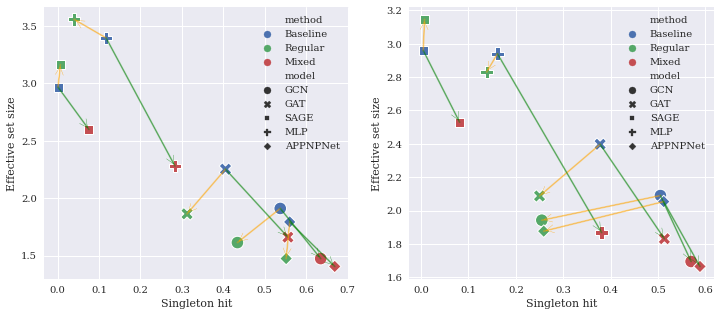

Computing Results in Fair Mode
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=19, val=19
class 1: train=19, val=19
class 2: train=19, val=19
class 3: train=19, val=19
class 4: train=19, val=19
class 5: train=19, val=19
class 6: train=19, val=19
class 7: train=19, val=19
class 8: train=19, val=19
class 9: train=19, val=19
class 10: train=19, val=19
class 11: train=19, val=19
class 12: train=19, val=19
class 13: train=19, val=19
class 14: train=19, val=19
class 15: train=19, val=19
class 16: train=19, val=19
class 17: train=19, val=19
class 18: train=19, val=19
class 19: train=19, val=19
class 20: train=19, val=19
class 21: train=19, val=19
class 22: train=19, val=19
class 23: train=19, val=19
class 24: train=19, val=19
class 25: train=19, val=19
class 26: train=19, val=19
class 27: train=19, val=19
class 28: train=19, val=19
class 29: train=19, val=19
class 30: train=19, val=19
class 31: train=19, val=19
class 32: train=19, val=19
class 33: train=19, val=19
class 

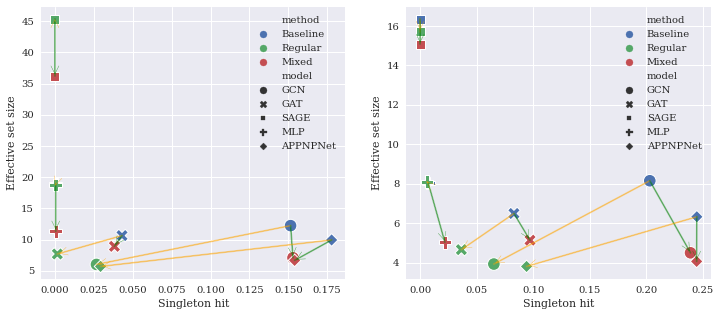

In [ ]:
selected_coverage = 0.92
dataset_manager = GraphDataManager(data_dir, splits_dir)
dataset_names = ["cora_ml_largest_component", "cora_full"]
for selected_dataset in dataset_names:
    f, axs = plt.subplots(1, 2, figsize=(12, 5))
    # fixed coverage
    dataset_results = get_overall_dataset_result(
        selected_dataset, selected_coverage, 
        coverage_mode="fixed", coverage_ratio=0.66,
        fair_mode=True)
    
    dataset_results.to_csv(os.path.join(dataframe_dir, f"{selected_dataset}-overall-fixed.csv"))
    average_result = dataset_results.groupby(
        ["model","method"], sort=False).mean().reset_index().drop(columns=["level_1", "instance"])
    
    pareto_plot(average_result, axs[0])
    
    # adaptive coverage
    dataset_results = get_overall_dataset_result(
        selected_dataset, selected_coverage, 
        coverage_mode="adaptive", coverage_ratio=0.66,
        fair_mode=True)
    
    dataset_results.to_csv(os.path.join(dataframe_dir, f"{selected_dataset}-overall-adaptive.csv"))
    average_result = dataset_results.groupby(
        ["model","method"], sort=False).mean().reset_index().drop(columns=["level_1", "instance"])
    
    pareto_plot(average_result, axs[1])
    plt.show()

## Results on Average for each Dataset/Model

['', 'Baseline', 'Regular', 'Mixed', '', 'GCN', 'GAT', 'SAGE', 'MLP', 'APPNPNet']
['', 'APS', 'RAPS', 'DAPS', '', 'GCN', 'GAT', 'SAGE', 'MLP', 'APPNPNet']


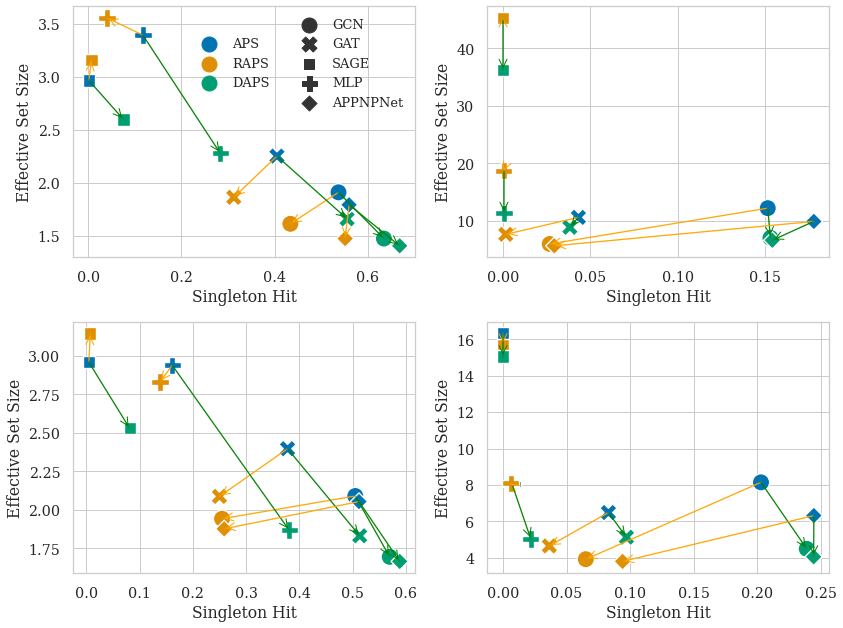

In [43]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
dataset_pretty_name = {"cora_ml_largest_component": "Cora ML largest component", "cora_full": "Cora full"}

def plot_result_df(result_plot, points_label="model", ax=None, annotate=True):
    sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
    sns.scatterplot(data=result_plot, x="singleton_hit", y="average_set_size", hue="method", style=points_label, ax=ax, s=300)

    for idx in result_plot[points_label].unique():
        to_point = lambda row: (row["singleton_hit"].values[0], row["average_set_size"].values[0])
        baseline_select = lambda x: x["method"] == "Baseline" and x[points_label] == idx
        regular_select = lambda x: x["method"] == "Regular" and x[points_label] == idx
        mixed_select = lambda x: x["method"] == "Mixed" and x[points_label] == idx
        baseline_point = to_point(result_plot[result_plot.apply(baseline_select, axis=1)])
        regular_point = to_point(result_plot[result_plot.apply(regular_select, axis=1)])
        mixed_point = to_point(result_plot[result_plot.apply(mixed_select, axis=1)])

        reg_line = ax.plot([baseline_point[0], regular_point[0]], [baseline_point[1], regular_point[1]], color="orange", alpha=0.3)[0]
        mix_line = ax.plot([baseline_point[0], mixed_point[0]], [baseline_point[1], mixed_point[1]], color="green", alpha=0.3)[0]
        add_arrow(reg_line, size=20)
        add_arrow(mix_line, size=20)
        ax.legend(loc="upper right")
        
        if annotate:
            ax.annotate(f"{idx}", (baseline_point[0] * 1.1, baseline_point[1]), fontsize=10)

    handles, labels = ax.get_legend_handles_labels()

    ax.set_xlabel("Singleton Hit")
    ax.set_ylabel("Effective Set Size")
    
f, axs = plt.subplots(2, 2, figsize=(12, 9))

handles, labels = None, None
for di, selected_dataset in enumerate(["cora_ml_largest_component", "cora_full"]):
    for mi, selected_mode in enumerate(["fixed", "adaptive"]):
        ax = axs[mi, di]
        loaded_df = pd.read_csv(os.path.join(dataframe_dir, f"{selected_dataset}-overall-{selected_mode}.csv"), index_col=0)
        plotable_df = loaded_df.groupby(["model", "method"], sort=False).mean().reset_index()
        _ = plot_result_df(plotable_df, points_label="model", ax=ax, annotate=False)
        
        ax.set_xlabel("Singleton Hit")
        ax.set_ylabel("Effective Set Size")
        
        if mi == 0 and di == 0:
            handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()

f.tight_layout()

labels = [""] + labels[1:4] +[""] + labels[5:]
labels[1] = "APS"
labels[2] = "RAPS"
labels[3] = "DAPS"

axs[0, 0].legend(handles, labels, loc='upper right', prop={'size': 13,}, markerscale=2.5, ncol=2, )

# lgd = f.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), prop={'size': 12,}, markerscale=2.5)
plt.savefig(os.path.join(figures_dir, "cora-largestcomponent-full-average.pgf"), format="pgf", bbox_inches='tight')

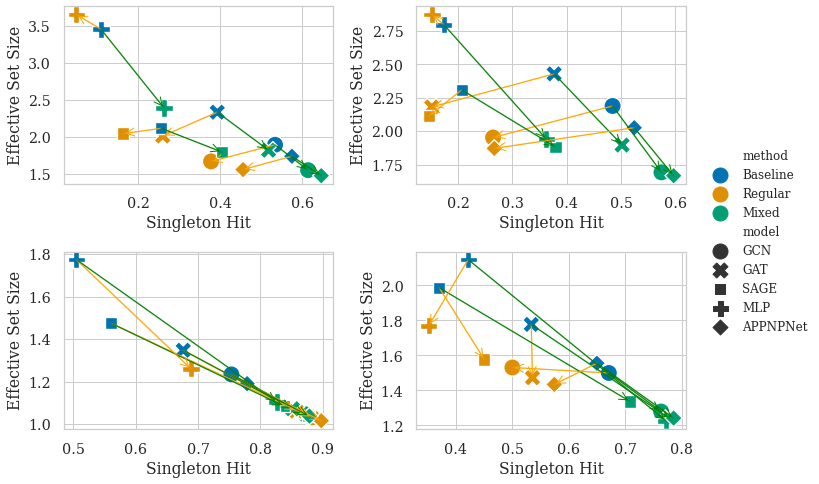

In [32]:
f, axs = plt.subplots(2, 2, figsize=(10, 7))

handles, labels = None, None
for di, selected_dataset in enumerate(["cora_ml","coauthor_physics",]):
    for mi, selected_mode in enumerate(["fixed", "adaptive"]):
        ax = axs[di, mi]
        loaded_df = pd.read_csv(os.path.join(figures_dir, f"{selected_dataset}-overall-{selected_mode}.csv"), index_col=0)
        plotable_df = loaded_df.groupby(["model", "method"], sort=False).mean().reset_index()
        _ = plot_result_df(plotable_df, points_label="model", ax=ax, annotate=False)
        
        ax.set_xlabel("Singleton Hit")
        ax.set_ylabel("Effective Set Size")
        
        if mi == 0 and di == 0:
            handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()

f.tight_layout()
lgd = f.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), prop={'size': 12,}, markerscale=2.5)
plt.savefig(os.path.join(figures_dir, "coauthor-mainpaper-networks-average.pgf"), format="pgf",  bbox_extra_artists=(lgd,), bbox_inches='tight')

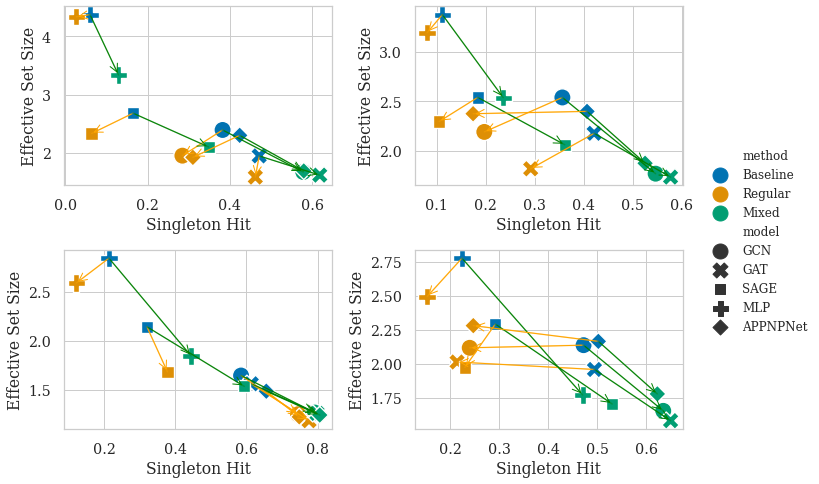

In [33]:
f, axs = plt.subplots(2, 2, figsize=(10, 7))
handles, labels = None, None
for di, selected_dataset in enumerate(["amazon_computers", "amazon_photo"]):
    for mi, selected_mode in enumerate(["fixed", "adaptive"]):
        ax = axs[di, mi]
        loaded_df = pd.read_csv(os.path.join(figures_dir, f"{selected_dataset}-overall-{selected_mode}.csv"), index_col=0)
        plotable_df = loaded_df.groupby(["model", "method"], sort=False).mean().reset_index()
        _ = plot_result_df(plotable_df, points_label="model", ax=ax, annotate=False)
        
        if mi == 0 and di == 0:
            handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()
        ax.set_xlabel("Singleton Hit")
        ax.set_ylabel("Effective Set Size")
        
        if mi == 0 and di == 0:
            handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()
f.tight_layout()
lgd, f.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), prop={'size': 12,}, markerscale=2.5)
plt.savefig(os.path.join(figures_dir, "copurchase-networks-average.pgf"), format="pgf", bbox_extra_artists=(lgd,), bbox_inches='tight')

## Stability Charts

In [23]:
def get_dataset_stability_instances(selected_dataset, selected_model, selected_coverage, coverage_mode="fixed", coverage_ratio=0.66, fair_mode=True):
    dataset = dataset_manager.get_dataset_from_key(selected_dataset).data
    models_results = []
    instances = make_dataset_instances(data_dir, splits_dir, splits_config, models_cache_dir, selected_dataset, selected_model, models_config)
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instances[0])
    tune_idxs = []
    test_idxs = []
    for instance in instances:
        tune_idx, test_idx = tune_truetest_split(instance["test_idx"], dataset, tune_fraction)
        tune_idxs.append(tune_idx)
        test_idxs.append(test_idx)

    if coverage_mode == "adaptive":
        mean_acc = np.mean([instance["accuracy"] for instance in instances])
        selected_coverage = coverage_ratio * 1.0 + (1 - coverage_ratio) * mean_acc
        selected_coverage = round(selected_coverage, 3)
        print(f"adaptive coverage with 1 - alpha = {selected_coverage} - Dataset = {selected_dataset}")

    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

    instance_results = []
    instance = instances[0]

    tune_idx = tune_idxs[0]
    test_idx = test_idxs[0]
    reg_enhancement, reg_params = find_all_regular_params(
        instance, dataset, selected_coverage, tune_idx, n_iterations=20)

    best_k_reg = reg_params[0]
    best_penalty = reg_params[1]

    mixing_enhancement, mixing_params = find_all_mixing_params(
        instance, dataset, selected_coverage, tune_idx, n_iterations=20)
    lambda_val = mixing_params[0]
    
    for instance_idx, instance in enumerate(instances):
        test_idx = test_idxs[instance_idx]
            
        if fair_mode:
            res_combined = compare_cps_fair(
                instance, dataset, selected_coverage, lambda_val=lambda_val, 
                k_reg=best_k_reg, penalty=best_penalty, true_test_idx=test_idx, calib_fraction=calib_fraction, tune_idx=tune_idx)
        else:
            res_combined = compare_cps(
                instance, dataset, selected_coverage, lambda_val=lambda_val, 
                k_reg=best_k_reg, penalty=best_penalty, true_test_idx=test_idx, calib_fraction=calib_fraction)
                
        res = res_combined["mean"]
        res_sd = res_combined["std"]

        instance_results.append(res)
    instance_results = pd.concat(instance_results, axis=0, keys=[idx for idx in range(len(instances))])
    return instance_results.reset_index().rename(columns={"level_0": "instance", "level_1": "method"})

Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644568 +- 0.009074238748131642
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644568 +- 0.009074238748131642
adaptive coverage with 1 - alpha = 0.94 - Dataset = cora_ml
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.9219753302423236 +- 0.012189321000885356
Dataset Loaded Succe

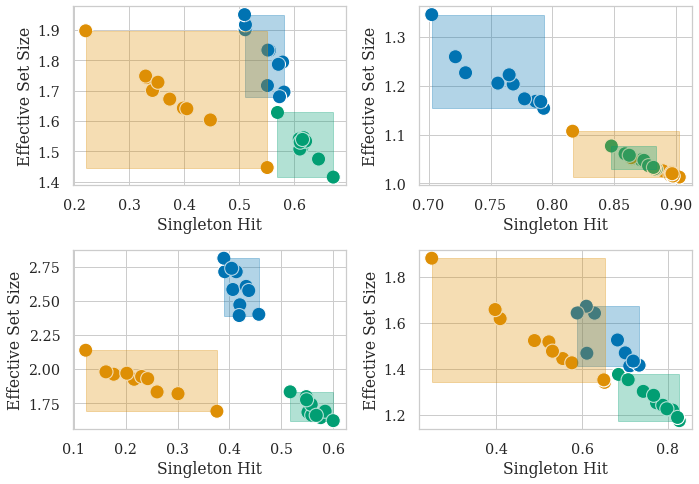

In [34]:
selected_dataset = "cora_ml"
selected_model = "GCN"
selected_coverage = 0.92

sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(2, 2, figsize=(10, 7))

def plot_instance_stability(selected_dataset, selected_model, selected_coverage, ax, coverage_mode="fixed", coverage_ratio=0.66, fair_mode=True):
    result_df = get_dataset_stability_instances(
        selected_dataset, selected_model, selected_coverage, coverage_mode, coverage_ratio, fair_mode)

    blue_x = result_df.loc[result_df["method"] == "Baseline", "singleton_hit"]
    blue_y = result_df.loc[result_df["method"] == "Baseline", "average_set_size"]

    orange_x = result_df.loc[result_df["method"] == "Regular", "singleton_hit"]
    orange_y = result_df.loc[result_df["method"] == "Regular", "average_set_size"]

    green_x = result_df.loc[result_df["method"] == "Mixed", "singleton_hit"]
    green_y = result_df.loc[result_df["method"] == "Mixed", "average_set_size"]

    sns.scatterplot(data=result_df, x="singleton_hit", y="average_set_size", ax=ax, hue="method", s=200)

    r_blue = Rectangle((blue_x.min(), blue_y.min()), blue_x.max() - blue_x.min(), blue_y.max() - blue_y.min(), color='#0173B2', alpha=0.3)
    r_orange = Rectangle((orange_x.min(), orange_y.min()), orange_x.max() - orange_x.min(), orange_y.max() - orange_y.min(), color='#DE8F05', alpha=0.3)
    r_green = Rectangle((green_x.min(), green_y.min()), green_x.max() - green_x.min(), green_y.max() - green_y.min(), color='#029E73', alpha=0.3)

    ax.add_patch(r_blue)
    ax.add_patch(r_orange)
    ax.add_patch(r_green)

    ax.set_xlabel("")
    ax.set_ylabel("")

for sd, selected_dataset in enumerate(["cora_ml", "coauthor_physics"]):
    for im, mode in enumerate(["fixed", "adaptive"]):
        ax = axs[im, sd]
        # if im == 0:
            # ax.set_title(dataset_pretty_name[selected_dataset])
        plot_instance_stability(selected_dataset, selected_model, selected_coverage, ax=ax, coverage_mode=mode, coverage_ratio=0.66, fair_mode=True)
        if mi == 0 and di == 0:
            handles, labels = ax.get_legend_handles_labels()
        # if im == 0 and sd == 0:
        #     ax.set_ylabel("Fixed Coverage")
        # if im == 1 and sd == 0:
        #     ax.set_ylabel("Adaptive Coverage")
        ax.set_xlabel("Singleton Hit")
        ax.set_ylabel("Effective Set Size")
        
        ax.legend().remove()
f.tight_layout()
# lgd, f.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), prop={'size': 12,}, markerscale=2.5)
plt.savefig(os.path.join(figures_dir, "instance-stability-mainpaper.pgf"), format="pgf", bbox_inches='tight')
# f.supxlabel("Singleton Hit")
# f.supylabel("Effective Set Size")


In [25]:
def get_dataset_stability_coverage(selected_dataset, selected_model, instance_idx=0, tuning_coverage_ratio=0.6, fair_mode=True):
    dataset = dataset_manager.get_dataset_from_key(selected_dataset).data
    models_results = []
    instances = make_dataset_instances(data_dir, splits_dir, splits_config, models_cache_dir, selected_dataset, selected_model, models_config)
    
    instance_accuracy = np.round(instances[0]["accuracy"], 3)
    tuning_coverage = 1.0 * tuning_coverage_ratio + instance_accuracy * (1 - tuning_coverage_ratio)
    
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instances[0])
    tune_idxs = []
    test_idxs = []
    for instance in instances:
        tune_idx, test_idx = tune_truetest_split(instance["test_idx"], dataset, tune_fraction)
        tune_idxs.append(tune_idx)
        test_idxs.append(test_idx)

    if coverage_mode == "adaptive":
        mean_acc = np.mean([instance["accuracy"] for instance in instances])
        selected_coverage = coverage_ratio * 1.0 + (1 - coverage_ratio) * mean_acc
        selected_coverage = round(selected_coverage, 3)
        print(f"adaptive coverage with 1 - alpha = {selected_coverage} - Dataset = {selected_dataset}")

    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

    instance_results = []
    instance = instances[instance_idx]

    tune_idx = tune_idxs[instance_idx]
    test_idx = test_idxs[instance_idx]
    reg_enhancement, reg_params = find_all_regular_params(
        instance, dataset, tuning_coverage, tune_idx, n_iterations=20)

    best_k_reg = reg_params[0]
    best_penalty = reg_params[1]

    mixing_enhancement, mixing_params = find_all_mixing_params(
        instance, dataset, tuning_coverage, tune_idx, n_iterations=20)
    lambda_val = mixing_params[0]
    
    instance = instances[instance_idx]
    
    test_idx = test_idxs[instance_idx]
    
    acc = np.round(instance["accuracy"], 3)
    
    coverage_vals = np.arange(acc, 0.97, 0.01).round(3)
    for selected_coverage in coverage_vals:
        if fair_mode:
            res_combined = compare_cps_fair(
                instance, dataset, selected_coverage, lambda_val=lambda_val, 
                k_reg=best_k_reg, penalty=best_penalty, true_test_idx=test_idx, calib_fraction=calib_fraction, tune_idx=tune_idx)
        else:
            res_combined = compare_cps(
                instance, dataset, selected_coverage, lambda_val=lambda_val, 
                k_reg=best_k_reg, penalty=best_penalty, true_test_idx=test_idx, calib_fraction=calib_fraction)
                
        res = res_combined["mean"]
        res_sd = res_combined["std"]
        

        instance_results.append(res)
    instance_results = pd.concat(instance_results, axis=0, keys=coverage_vals)
    return instance_results.reset_index().rename(columns={"level_0": "coverage", "level_1": "method"})

Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644568 +- 0.009074238748131642


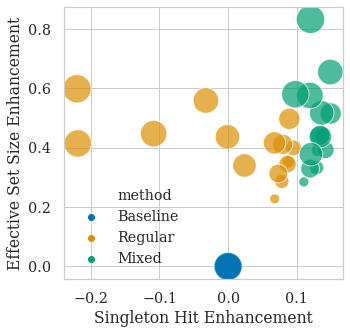

In [39]:
selected_dataset = "cora_ml"
selected_model = "GCN"
selected_instance = 0

result_df = get_dataset_stability_coverage(
    selected_dataset, selected_model, instance_idx=0, tuning_coverage_ratio=0.6, fair_mode=True)
result_df["baseline_set_size"] = result_df.apply(
    lambda row: result_df.loc[(result_df["coverage"] == row["coverage"]) & (result_df["method"] == "Baseline"), "average_set_size"
                             ].values[0], axis=1)
result_df["average_set_size_enhancement"] = result_df["baseline_set_size"] - result_df["average_set_size"]


result_df["baseline_singleton_hit"] = result_df.apply(
    lambda row: result_df.loc[(result_df["coverage"] == row["coverage"]) & (result_df["method"] == "Baseline"), "singleton_hit"
                             ].values[0], axis=1)
result_df["singleton_hit_enhancment"] = result_df["singleton_hit"] - result_df["baseline_singleton_hit"]

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=result_df, x="singleton_hit_enhancment", 
                y="average_set_size_enhancement", hue="method", 
                size="coverage", sizes=(100, 800), alpha=0.7, ax=ax)
ax.set_ylabel("Effective Set Size Enhancement")
ax.set_xlabel("Singleton Hit Enhancement")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4])

plt.savefig(os.path.join(figures_dir, "coverage-stability-mainpaper.pgf"), format="pgf", bbox_inches='tight')